# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install ipywidgets

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.session import Session
import os

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-11-29 12:54:26--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.72
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  48.3MB/s    in 24s     

2022-11-29 12:54:59 (44.5 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [5]:
session=sagemaker.Session()
bucket= bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))
role = get_execution_role()
print("role ",role)
prefix="dogImage"
#data_s3=session.upload_data(path="dogImages",bucket=bucket,key_prefix=prefix)

Default Bucket: sagemaker-us-east-1-310724489955
role  arn:aws:iam::310724489955:role/service-role/AmazonSageMaker-ExecutionRole-20221121T093902


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
#TODO: Declare your HP ranges, metrics etc.
hyperparameters = {"test-batch-size": "100" }
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64,128,256]),
    "epochs": IntegerParameter(2,8)
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [16]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch
s3_output_location = f"s3://{bucket}/modelimgHpo/"
estimator =  PyTorch(
    entry_point="hpo.py",
    base_job_name="classification-dogImg-modehPO",
    role=role,
    hyperparameters=hyperparameters,
    output_path= s3_output_location,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    framework_version="1.8",
    py_version="py36",
)# TODO: Your estimator here


In [17]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)# TODO: Your HP tuner here

In [14]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
    "train": f"s3://{bucket}/dogImage/train/",
    "test":f"s3://{bucket}/dogImage/test/",
    "val": f"s3://{bucket}/dogImage/valid/"
}

In [18]:
# TODO: Fit your HP Tuner
tuner.fit(model_inputs,wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [19]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
bestHpoTr = best_estimator.hyperparameters()
bestHpoTr


2022-12-01 11:39:52 Starting - Preparing the instances for training
2022-12-01 11:39:52 Downloading - Downloading input data
2022-12-01 11:39:52 Training - Training image download completed. Training in progress.
2022-12-01 11:39:52 Uploading - Uploading generated training model
2022-12-01 11:39:52 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'epochs': '4',
 'lr': '0.01179859735727861',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"classification-dogImg-modehPO-2022-12-01-10-29-51-875"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-310724489955/classification-dogImg-modehPO-2022-12-01-10-29-51-875/source/sourcedir.tar.gz"',
 'test-batch-size': '"100"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [22]:
# TODO: Set up debugging and profiling rules and hooks
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile,
    ProfilerRule,
    rule_configs,
)
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),    
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "5"},
    collection_configs = [CollectionConfig(name = "CrossEntropyLoss_output_0",
                                           parameters = {
                                               "include_regex": "CrossEntropyLoss_output_0",
                                               "train.save_interval": "10",
                                               "eval.save_interval": "1"})]
)

In [23]:
hyperparameters={'batch-size': 128,
                 'lr': 0.01179859735727861,
                 "epochs": 4,
                 'test-batch-size': "100"}

In [24]:
# TODO: Create and fit an estimator

s3_output_location = f"s3://{bucket}/outputbestClassification/"

estimator = PyTorch(
    role=role,
    base_job_name = "best-image-Cls",
    output_path= s3_output_location,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=hook_config,
    rules=rules,
)

estimator.fit(model_inputs,wait=True)

2022-12-01 11:49:31 Starting - Starting the training job...
2022-12-01 11:49:50 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-12-01 11:51:27 Downloading - Downloading input data......
2022-12-01 11:52:28 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-01 11:52:23,993 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-01 11:52:23,995 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-01 11:52:24,003 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-01 11:52:24,011 sagemaker_pytorch_container.training INFO 

In [25]:
# TODO: Plot a debugging output.
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Session name: {session}")
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Session name: Session(region_name='us-east-1')
Training jobname: best-image-Cls-2022-12-01-11-49-31-171
Region: us-east-1


In [26]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())


print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-12-01 13:04:50.618 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-310724489955/outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/debug-output
[2022-12-01 13:04:53.895 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-12-01 13:04:54.915 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'l

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


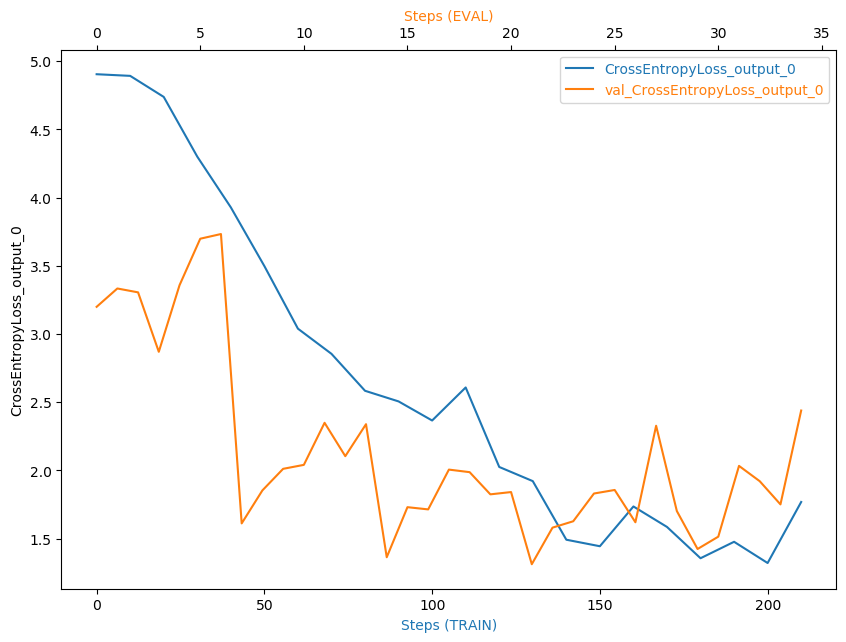

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [28]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f" profiler report  {rule_output_path}")

 profiler report  s3://sagemaker-us-east-1-310724489955/outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output


In [29]:
! aws s3 ls {rule_output_path} --recursive

2022-12-01 13:01:48     375646 outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-12-01 13:01:47     223568 outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-12-01 13:01:43        192 outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-12-01 13:01:43        200 outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-12-01 13:01:43       2098 outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-12-01 13:01:43        127 outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIn

In [30]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-310724489955/outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-310724489955/outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-310724489955/outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-310724489955/outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profil

In [31]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [32]:
profiler_report_name

'ProfilerReport'

In [44]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [35]:
# TODO: Deploy your model to an endpoint
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m5.large") # TODO: Add your deployment configuration like instance type and number of instances

------!

In [36]:
endpoint_name = predictor.endpoint_name
endpoint_name

'best-image-Cls-2022-12-01-13-27-16-558'

In [37]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-310724489955/outputbestClassification/best-image-Cls-2022-12-01-11-49-31-171/output/model.tar.gz


In [39]:
# TODO: Run an prediction on the endpoint
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    
    def __init__(self, endpoint_name, session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
model_location = "s3://sagemaker-us-east-1-310724489955/best-image-Cls-2022-12-01-13-27-16-558/model.tar.gz"
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

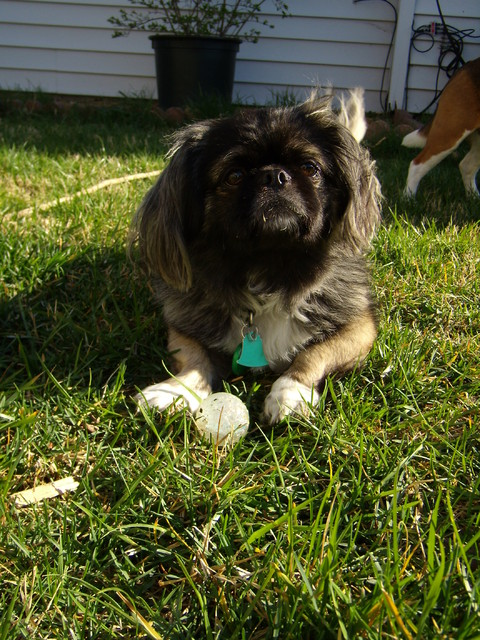

Response: [[-6.59622859954834, -13.152351379394531, -14.71104907989502, -6.213049411773682, -16.551536560058594, -15.058326721191406, -11.057578086853027, -6.305901050567627, -10.951178550720215, -5.201156139373779, -14.475451469421387, -13.87332820892334, -11.343169212341309, -12.336675643920898, -10.599885940551758, -10.218171119689941, -7.5986738204956055, -17.28449058532715, -5.965041637420654, -15.614086151123047, -19.865550994873047, -16.439546585083008, -20.64568328857422, -5.370481967926025, -9.899090766906738, -8.50136661529541, -5.894488334655762, -15.689128875732422, -17.11937713623047, -2.6629865169525146, -14.348991394042969, -11.378287315368652, -6.564919948577881, -6.707720756530762, -10.706258773803711, -7.030586242675781, -16.552095413208008, -6.456463813781738, -14.241883277893066, -5.144114971160889, -3.3888497352600098, -9.067925453186035, -9.788804054260254, -4.18852424621582, -6.7184977531433105, -12.558252334594727, -11.507524490356445, -10.763406753540039, -8.80

In [40]:
from sagemaker.serializers import IdentitySerializer
import base64
from PIL import Image
import io

with open("Pekingese_07585.jpg", "rb") as f:
    payload = f.read()
    display(Image.open(io.BytesIO(payload)))
    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}")



In [41]:
import numpy as np
np.argmax(response, 1)

array([49])

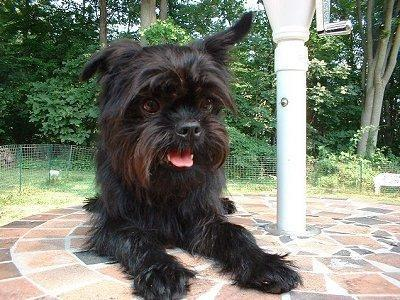

Response: [[-9.276472091674805, -15.946334838867188, -33.25751495361328, -38.119441986083984, -48.167240142822266, -50.420631408691406, -42.82955551147461, -25.79473304748535, -15.578546524047852, -24.13231658935547, -31.570343017578125, -33.16252517700195, -20.50132942199707, -37.10248565673828, -30.203964233398438, -40.40401077270508, -15.537535667419434, -36.51283645629883, -14.906027793884277, -42.62480163574219, -38.94367599487305, -40.417598724365234, -47.518898010253906, -28.054956436157227, -18.333051681518555, -13.513754844665527, -12.263055801391602, -32.24272537231445, -38.227046966552734, -10.550509452819824, -30.566219329833984, -37.25501251220703, -12.728789329528809, -27.55815887451172, -15.3392915725708, -13.350804328918457, -46.86065673828125, -15.645672798156738, -45.08611297607422, -34.49794387817383, -21.56922721862793, -18.310869216918945, -31.66115379333496, -16.576765060424805, -28.923152923583984, -25.291093826293945, -24.94943618774414, -28.820463180541992, -13

In [42]:
with open("Affenpinscher_00001.jpg", "rb") as f:
    payload = f.read()
    display(Image.open(io.BytesIO(payload)))
    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}")
    print(f"categorie: {np.argmax(response, 1)}")

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()